In [1]:
#Script para identificar determinantes de citações na base USPTO
#Renato Kogeyama

#10-11-2019
#I introduced log backward citation, what corrects for very dispersed results
#but the major problem is that few patents receive citations
#bring back binary output

#10-10-2019
#Added graphics and new distributions

#09-15-2019
#O naive bayes tem algum problema com distribuicoes desbalanceadas
#o scikit learn tem um modulo que corrige count distributions com muitos zeros, o complementNB
#porem este nao esta disponivel na atual versao disponibilizada no HPC da FIU

#09-10-2019
#o trabalho pede uma abordagem mais sistematica e cuidadosa
#estou agrupando o codigo antigo comentado e vou comecar um novo codigo

#09-17-2018

#Alto uso de memoria - rodar no Amazon AWS 
#Notebook 2

In [2]:
import pandas as pd
import numpy as np

# import math
# from IPython.display import display

from sklearn import linear_model
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from sklearn.metrics import roc_curve, auc
from scipy import stats
import datetime
import pylab as pl

import random

In [3]:
#regression

def linear_reg(df, chosenColumns):
    myX = df.as_matrix(columns=chosenColumns)
    myY = df.as_matrix(columns=['citation_bi'])

    xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
    testSize = yTest.shape[0]
    trainSize = yTrain.shape[0]

    print("Test Size:", testSize)
    print("Train Size:", trainSize)
    print("\n")

    linear=linear_model.LinearRegression()
    linear.fit(xTrain, yTrain)

    trainingPredictions=linear.predict(xTrain)
#     print("Some values predicted by model", trainingPredictions[0:5], trainingPredictions[-6:-1])

    confusionMatTrain=confusionMatrix(trainingPredictions, yTrain, 0.5)
    tp=confusionMatTrain[0];fn=confusionMatTrain[1]
    fp=confusionMatTrain[2];tn=confusionMatTrain[3]

    print('Confusion Matrix for Training data')
    print("tp="+str(tp)+"\tfn="+str(fn)+"\n"+'fp='+str(fp)+'\ttn='+str(tn)+'\n')

    testPredictions=linear.predict(xTest)

    confusionMatTest=confusionMatrix(testPredictions, yTest, 0.5)
    tp=confusionMatTest[0];fn=confusionMatTest[1]
    fp=confusionMatTest[2];tn=confusionMatTest[3]

    print('Confusion Matrix for Test data')
    print("tp="+str(tp)+"\tfn="+str(fn)+"\n"+'fp='+str(fp)+"\ttn="+str(tn)+'\n')

    fpr, tpr, thresholds=roc_curve(yTrain, trainingPredictions)
    roc_auc=auc(fpr, tpr)

    print('AUC for in-sample ROC curve: %f' % roc_auc)

    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area=%0.2f)' % roc_auc)
    pl.plot([0,1], [0,1], 'k-')
    # pl.xlim([0.0,1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('In sample ROC')
    pl.legend(loc='lower right')
    pl.show()

    return

In [4]:
# # Naive Bayes
def test_naive_bayes(dataset, chosenColumns):

#     chosenColumns = ['num_claims', 'forward_citation','year', 'month', 'day']

    myX = dataset.as_matrix(columns=chosenColumns)
    # myY = df2.as_matrix(columns=['backward_citation'])
    myY = dataset.as_matrix(columns=['citation_bi'])
#     myY = dataset.as_matrix(columns=['log_back_cit'])

    xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
    testSize = yTest.shape[0]


    # nb = naive_bayes.GaussianNB()

    # dado que o output eh count, uma distribuicao multinomial se adapta melhor
    nb = naive_bayes.MultinomialNB()

    # complementNB adapta o MultinomialNB para datasets muito desbalanceados
    # porem nao esta disponivel para a versao 0.19 do scikit-learn
    # nb = naive_bayes.ComplementNB()

    nb.fit(xTrain, yTrain.ravel())
    
    trainingPredict = nb.predict(xTrain) # predicting test data

    yPredNB = nb.predict(xTest) # predicting test data

    # computing error
    errorNB = np.sum((yPredNB[i] != yTest[i]) for i in range(0, testSize))
    errorNBPCT = int(100*errorNB/testSize)
    hitRateNBPCT = 100 - errorNBPCT
    
    fpr, tpr, thresholds=roc_curve(yTrain, trainingPredict)
    print("----------Naive Bayes----------")
    print(int(errorNB), "misclassified data out of", testSize)
    print("Error PCT: ",errorNBPCT,'%')
    print("Hit Rate:  ",hitRateNBPCT,'%')

    roc_auc=auc(fpr, tpr)

    print('AUC for in-sample ROC curve: %f' % roc_auc)

    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area=%0.2f)' % roc_auc)
    pl.plot([0,1], [0,1], 'k-')
    # pl.xlim([0.0,1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('In sample ROC')
    pl.legend(loc='lower right')
    pl.show()

    return
   

In [5]:
# K Nearest Neighbors
def test_knn(dataset,chosenColumns):
#     chosenColumns = ['num_claims','year', 'month', 'day', 'type_plant',
#            'type_reissue', 'type_statutory invention registration', 'type_utility',
#            'kind_A', 'kind_B1', 'kind_B2', 'kind_E', 'kind_E1', 'kind_H', 'kind_P',
#            'kind_P2', 'kind_P3', 'forward_citation']
    

    myX = dataset.as_matrix(columns=chosenColumns)
    myY = dataset.as_matrix(columns=['citation_bi'])

    xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
    testSize = yTest.shape[0]

    myK = 5

    knn =  KNeighborsClassifier(n_neighbors=myK)
    knn.fit(xTrain, yTrain.ravel())
    yPredKNN = knn.predict(xTest) # predicting test data

    # computing error
    errorKNN = np.sum((yPredKNN[i] != yTest[i]) for i in range(0, testSize))
    errorKNNPCT = int(100*errorKNN/testSize)
    hitRateKNNPCT = 100 - errorKNNPCT

    print("----------K Nearest Neighbors----------")
    print(int(errorKNN), "misclassified data out of", testSize)
    print("Error PCT: ",errorKNNPCT,'%')
    print("Hit Rate:  ",hitRateKNNPCT,'%')
    
    
    fpr, tpr, thresh = roc_curve(yTest.ravel(), yPredKNN.ravel())

    roc_auc=auc(fpr, tpr)

    print('AUC for in-sample ROC curve: %f' % roc_auc)

    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area=%0.2f)' % roc_auc)
    pl.plot([0,1], [0,1], 'k-')
    # pl.xlim([0.0,1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('In sample ROC')
    pl.legend(loc='lower right')
    pl.show()

#     rocAuc = auc(fpr, tpr)
    return

In [6]:
def confusionMatrix(predicted, actual, threshold):
    if len(predicted)!=len(actual): return -1
    tp=0.0
    fp=0.0
    tn=0.0
    fn=0.0
    for i in range(len(actual)):
        if actual[i]>0.5: #labels that are 1.0 (positive examples)
            if predicted[i]>threshold:
                tp+=1.0 #correctly predicted positive
            else:
                fn+=1.0 #incorrectly predicted negative
        else: #labels that are 0.0 (negative examples)
            if predicted[i]<threshold:
                tn+=1.0 #correctly predicted negative
            else:
                fp+=1.0 #incorrectly predicted positive
    rtn=[tp, fn, fp, tn]
    return rtn

In [7]:
%matplotlib inline
# %matplotlib notebook

In [8]:
# #sampling the file
# fname='df_w_pat_cit_191003.csv'
# # sample_df='sample_df_w_pat_cit_190926.csv'
# n = sum(1 for line in open(fname)) - 1 #number of records in file (excludes header)
# s = 100000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
# df = pd.read_csv(fname, skiprows=skip, dtype={"id": object, "number": object}, index_col=0,usecols=[1,2,5,8,9,11,12,13,14,15])

In [9]:
# Read the file

df=pd.read_csv('/home/rkogeyam/PATENT_CITATION/df_w_pat_cit_191003.csv', sep=',', index_col=0, usecols=[1,2,5,8,9,11,12,13,14,15])

print("Testing for null values")
# Identify null variables
pd.isnull(df).sum() > 0

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Testing for null values


type                  True
date                  True
kind                  True
num_claims            True
forward_citation     False
backward_citation    False
year                  True
month                 True
day                   True
dtype: bool

In [10]:
# print(df[df.isnull().any(axis=1)])

In [11]:
# Check the Dataset
def uniqueColValues(auxdf):
    for column in auxdf:
        print("{} | {} | {}".format(
            auxdf[column].name, len(auxdf[column].unique()), auxdf[column].dtype
        ))
        
uniqueColValues(df)

type | 10 | object
date | 2219 | object
kind | 16 | object
num_claims | 392 | float64
forward_citation | 986 | float64
backward_citation | 520 | float64
year | 43 | float64
month | 13 | float64
day | 32 | float64


### Variables

Original data: 
(PatentsView: patents.tsv)
* type:	category of patent. Usually "Design", "reissue", etc. | Categorical
* number: patent number | Categorical
* date:	date when patent was granted | Numerical/Date
    * converted to year, month and day
* kind:	WIPO document kind codes | Categorical
* num_claims: number of claims | Numerical

(PatentsView: uspatentcitation.tsv)
* forward_citation: citations made by a patent | Numerical

#### Dependent Variable
* backward_citation: citations received by a patent | Numerical 
* log_back_cit: log of backward citation
* citation_bi: 1 if patent received any citation, 0 otherwise


#### Dropped Variables
* id: patent this record corresponds to (dropped)
* country: country in which patent was granted (always US) (dropped)
* abstract:	abstract text of patent
* title: title of patent
* filename: name of the raw data file where patent information is parsed from


In [12]:
df.shape

(6488261, 9)

In [13]:
df=df.dropna()
df.shape

(6488250, 9)

In [14]:
#log transformation of backward citation
df['log_back_cit'] = np.log(df.backward_citation+1)

#choose between backward citation or log back cit
dependent_variable='backward_citation'
# dependent_variable='log_back_cit'
# dependent_variable='citation_bi'

In [15]:
# Generate a binary output for simpler tests
df['citation_bi']=0
df.loc[df.backward_citation>0, 'citation_bi']=1

# Convert categorical to binary
# df=pd.get_dummies(df, columns=['type', 'kind', 'country'])
# df=pd.get_dummies(df, columns=['type', 'kind'])
print("Summary Statistics")
df.describe()[:][:3].round(2) #to make the table more readable, round(2) and drop the quantile data

Summary Statistics


,num_claims,forward_citation,backward_citation,year,month,day,log_back_cit,citation_bi
count,6488250.00,6488250.00,6488250.00,6488250.00,6488250.00,6488250.00,6488250.00,6488250.00
mean,14.14,2.18,1.12,2002.72,6.59,15.64,0.19,0.09
std,12.00,17.55,7.45,11.32,3.40,8.83,0.66,0.29


In [16]:
print("Cross correlation table")
df.corr().round(2)

Cross correlation table


,num_claims,forward_citation,backward_citation,year,month,day,log_back_cit,citation_bi
num_claims,1.00,-0.05,-0.09,0.15,0.00,-0.00,-0.22,-0.25
forward_citation,-0.05,1.00,0.15,0.08,0.02,0.00,0.23,0.23
backward_citation,-0.09,0.15,1.00,-0.00,0.00,-0.00,0.69,0.47
year,0.15,0.08,-0.00,1.00,0.00,-0.01,-0.00,0.01
month,0.00,0.02,0.00,0.00,1.00,0.00,-0.00,-0.01
day,-0.00,0.00,-0.00,-0.01,0.00,1.00,-0.00,-0.00
log_back_cit,-0.22,0.23,0.69,-0.00,-0.00,-0.00,1.00,0.90
citation_bi,-0.25,0.23,0.47,0.01,-0.01,-0.00,0.90,1.00


Heat Map - Cross correlation


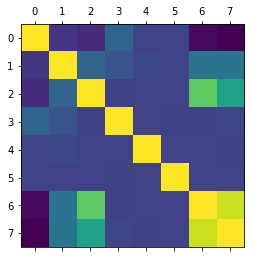

In [17]:
print("Heat Map - Cross correlation")
plot.matshow(df.corr())
plot.show()

In [18]:
# df.columns.values

In [19]:
# display.display(df)

In [20]:
# df=df.fillna(0)

In [21]:
df.shape

(6488250, 11)

In [22]:
# dealing with outliers 

df3=df._get_numeric_data()

print("df3.shape")
print(df3.shape)

mean=df3.mean(axis=0)
std_dev=df3.std(axis=0)
threshold=3*std_dev

if dependent_variable=='backward_citation':
    df3=df3[df3.backward_citation-mean.backward_citation<threshold.backward_citation]
else:
    df3=df3[df3.log_back_cit-mean.log_back_cit<threshold.log_back_cit]


df3.shape
(6488250, 8)


In [23]:
# patents with more than 3 citations

if dependent_variable=='backward_citation':
    df2=df3[df3.backward_citation>3]
else:
    df2=df3[df3.log_back_cit>np.log(3)]
    
df2.shape

(340918, 8)

In [24]:
# df.backward_citation.hist()
# pl.suptitle("Backward Citation Histogram")

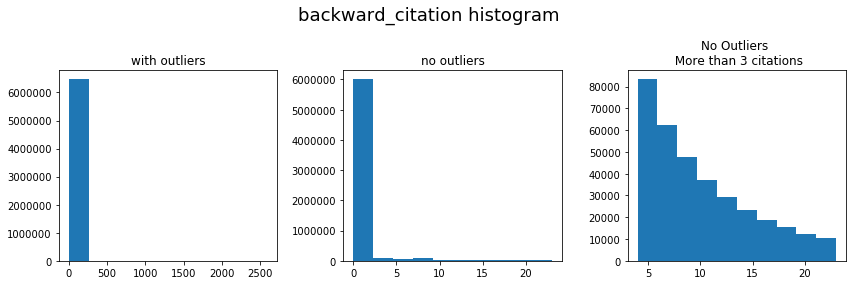

In [25]:
f, axs = plot.subplots(1,3,figsize=(12,4), sharey=True)
title=dependent_variable+' histogram'
plot.suptitle(title, fontsize=18)

plot.subplot(1, 3, 1)
plot.title('with outliers')
plot.hist(df[dependent_variable])

plot.subplot(1, 3, 2)
plot.title('no outliers')
plot.hist(df3[dependent_variable])

plot.subplot(1, 3, 3)
plot.title('No Outliers \n More than 3 citations')
plot.hist(df2[dependent_variable])

plot.tight_layout() #diminui o overlap entre os graficos
plot.subplots_adjust(top=0.76)

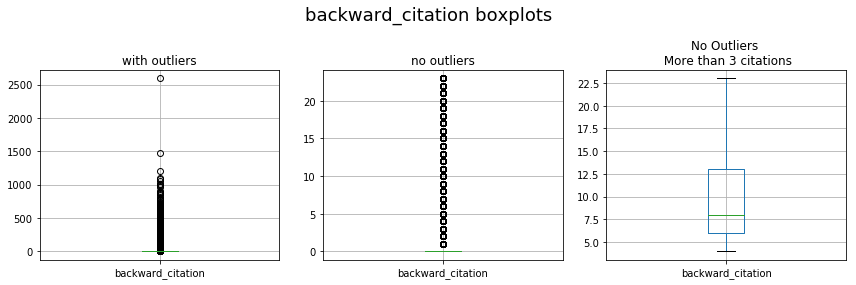

In [26]:
f, axs = plot.subplots(1,3,figsize=(12,4))
title=dependent_variable+' boxplots'
plot.suptitle(title, fontsize=18)

plot.subplot(1, 3, 1)
plot.title('with outliers')
df.boxplot([dependent_variable],return_type='axes')

plot.subplot(1, 3, 2)
plot.title('no outliers')
df3.boxplot([dependent_variable],return_type='axes')

plot.subplot(1, 3, 3)
plot.title('No Outliers \n More than 3 citations')
df2.boxplot([dependent_variable],return_type='axes')

plot.tight_layout() #diminui o overlap entre os graficos
plot.subplots_adjust(top=0.76)

In [27]:
df.groupby(['type']).mean().round(1)

,num_claims,forward_citation,backward_citation,year,month,day,log_back_cit,citation_bi
type,,,,,,,,
TVPP,14.0,0.0,0.0,1982.7,7.7,9.7,0.0,0.0
defensive publication,7.6,0.0,2.1,1979.7,6.4,4.0,0.7,0.6
design,1.0,14.5,9.6,2003.7,6.6,15.7,1.8,0.8
plant,1.0,0.4,0.4,2003.7,6.6,15.8,0.2,0.2
reissue,24.6,22.7,7.1,1999.7,6.6,15.8,1.1,0.6
statutory invention registration,10.2,6.5,0.0,1993.8,6.5,4.1,0.0,0.0
utility,15.4,0.9,0.3,2002.6,6.6,15.6,0.0,0.0


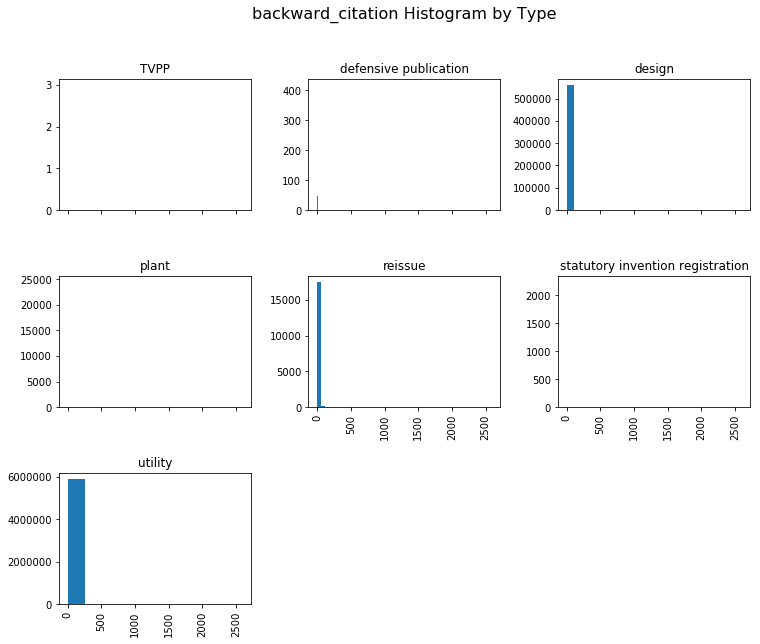

In [28]:
df[dependent_variable].hist(by=df['type'], figsize=[12,10], sharex=True)
title=dependent_variable+' Histogram by Type'
pl.suptitle(title, fontsize=16)
plot.subplots_adjust(top=0.88)
#option figsize establishes the total size of the figure
#option sharex makes all figures share the same x axis

In [29]:
df.groupby(['kind']).mean().round(1)

,num_claims,forward_citation,backward_citation,year,month,day,log_back_cit,citation_bi
kind,,,,,,,,
A,13.1,0.0,0.0,1990.9,6.6,15.7,0.0,0.0
B1,18.4,1.4,1.4,2006.9,6.4,15.5,0.1,0.1
B2,16.8,1.6,0.3,2011.4,6.6,15.6,0.1,0.0
E,20.1,11.6,9.4,1988.8,6.6,15.8,1.4,0.7
E1,28.9,33.3,5.0,2010.1,6.5,15.7,0.9,0.5
H,9.9,6.2,0.0,1992.1,6.5,4.2,0.0,0.0
H1,12.8,9.1,0.1,2006.3,6.5,4.0,0.1,0.1
I4,7.6,0.0,2.1,1979.7,6.4,4.0,0.7,0.6
I5,14.0,0.0,0.0,1982.7,7.7,9.7,0.0,0.0


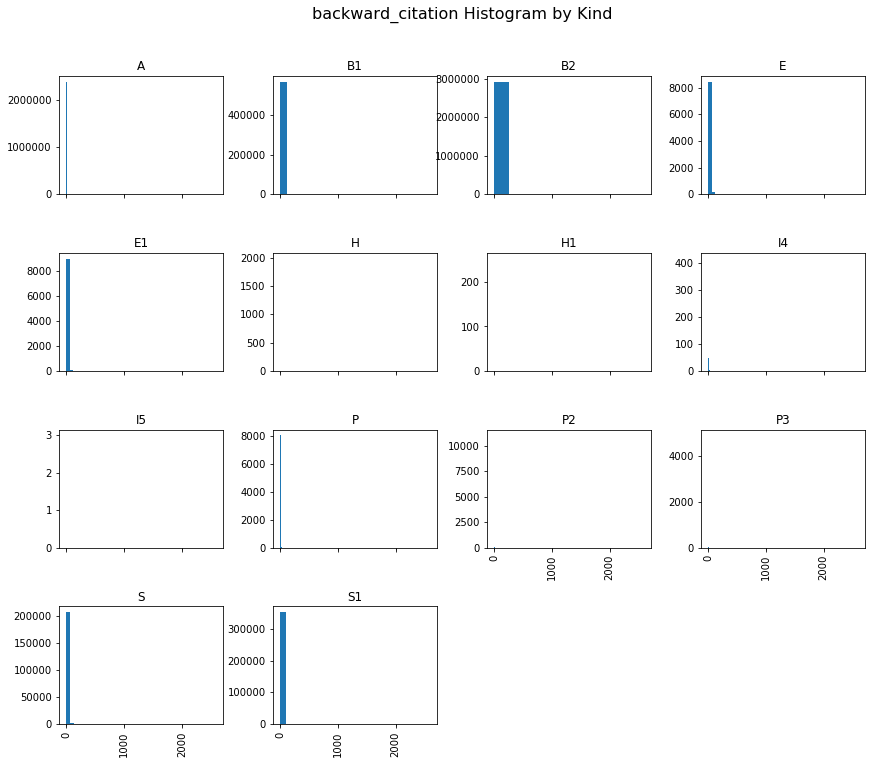

In [30]:
df[dependent_variable].hist(by=df['kind'], figsize=[14,12], sharex=True)
title=dependent_variable+" Histogram by Kind"
pl.suptitle(title, fontsize=16)


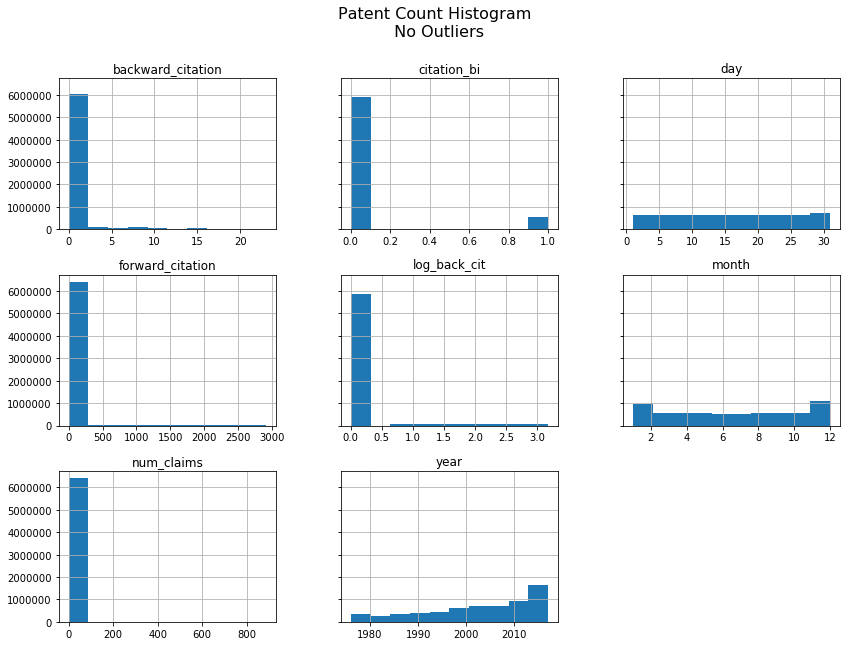

In [31]:
df3.hist(figsize=[14,10], sharey=True)
pl.suptitle("Patent Count Histogram \n No Outliers", fontsize=16)
plot.subplots_adjust(top=0.88)

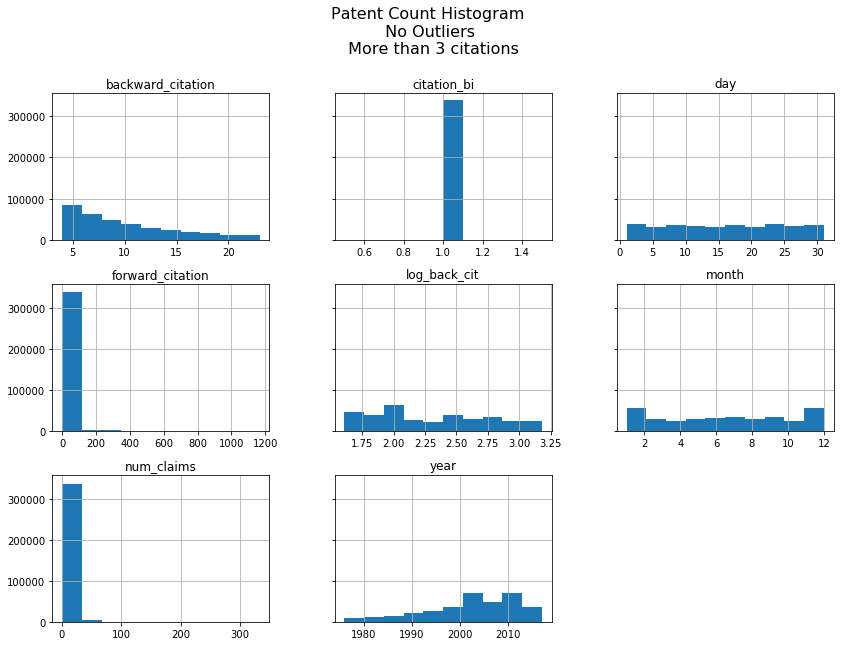

In [32]:
df2.hist(figsize=[14,10], sharey=True)
pl.suptitle("Patent Count Histogram \n No Outliers \n More than 3 citations", fontsize=16)
plot.subplots_adjust(top=0.86)

In [33]:
# df['num_claims']=df['num_claims'].astype(str).astype(float)

In [34]:
df.columns

Index(['type', 'date', 'kind', 'num_claims', 'forward_citation',
       'backward_citation', 'year', 'month', 'day', 'log_back_cit',
       'citation_bi'],
      dtype='object')

In [35]:
df3.columns

Index(['num_claims', 'forward_citation', 'backward_citation', 'year', 'month',
       'day', 'log_back_cit', 'citation_bi'],
      dtype='object')

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Test Size: 1946475


Confusion Matrix for Training data
tp=5510.0	fn=418927.0
fp=4579.0	tn=4112759.0

Confusion Matrix for Test data
tp=2409.0	fn=179926.0
fp=1949.0	tn=1762191.0

AUC for in-sample ROC curve: 0.911936


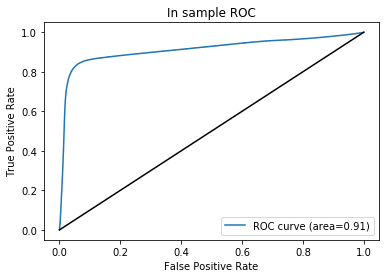

In [36]:
# chosenColumns = ['num_claims','year']
chosenColumns = ['num_claims', 'forward_citation','year', 'month', 'day']
linear_reg(df, chosenColumns)


/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


----------Naive Bayes----------
417583 misclassified data out of 1946475
Error PCT:  21 %
Hit Rate:   79 %
AUC for in-sample ROC curve: 0.802915


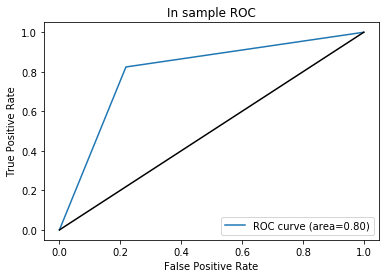

In [37]:
#naive bayes with complete dataset

chosenColumns = ['num_claims','year']
test_naive_bayes(df, chosenColumns)


/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


----------Naive Bayes----------
401147 misclassified data out of 1924595
Error PCT:  20 %
Hit Rate:   80 %
AUC for in-sample ROC curve: 0.809598


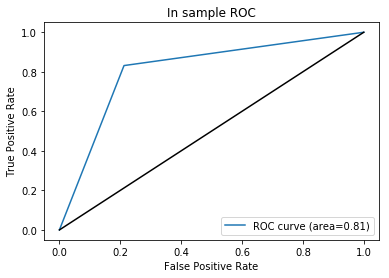

In [38]:
# #naive bayes without outliers
chosenColumns = ['num_claims','year']
test_naive_bayes(df3, chosenColumns)


/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


----------K Nearest Neighbors----------
99991 misclassified data out of 1946475
Error PCT:  5 %
Hit Rate:   95 %
AUC for in-sample ROC curve: 0.878288


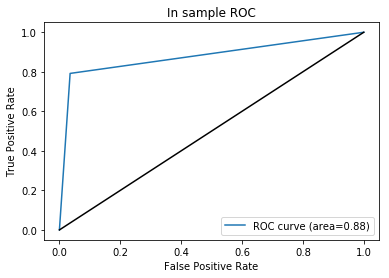

In [39]:
# Constructing the ROC curve and AUC
chosenColumns = ['num_claims','year']
test_knn(df, chosenColumns)
